# Tutorial sobre la Técnica de Clasificación de Regresión Logística

## 1. Fundamentos de la técnica

La Regresión Logística es un algoritmo de aprendizaje supervisado para tareas de clasificación, como los que se han visto en tutoriales previos.
Este algoritmo, y a diferencia de la regresión lineal que predice valores continuos, busca predecir la probabilidad de que una instancia pertenezca a una clase categórica.

A grandes rasgos, se basa en transformar la salida de una ecuación lineal usando una función sigmoide y acotando el resultado entre 0 y 1. Si la probabilidad es mayor o menor a un umbral, se determina si se clasifica de una forma u otra. 

Cabe aclarar que esto último es asumiendo que se trabaja con una clase con dos valores, es decir, una Regresión logística binaria; sin embargo, también existen otros tipos como la Regresión logística multinomial y la Regresión logística ordinal, las cuales trabajan con 3 o más resultados posibles para su clase.

## 2. Modelo matemático

Nos enfocaremos en la regresión logística binaria. Esta modela la probabilidad $P(y=1|X)$ usando la función sigmoide o logística.

La función de hipótesis se define como:
$$h_\theta(x) = \sigma(z) = \frac{1}{1 + e^{-z}}$$

Donde $z$ es la combinación lineal de las características de entrada (también conocido como "logit" o "log-odds"):
$$z = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + ... + \theta_n x_n$$

* Si $h_\theta(x) \geq 0.5$, entonces $y=1$.
* Si $h_\theta(x) < 0.5$, entonces $y=0$.

El entrenamiento busca encontrar los parámetros $\theta$ que minimicen la función de costo (Log-Loss).

## 3. Descripción de las librerías, clases y funciones

Para este tutorial se utilizarán las siguientes herramientas del ecosistema científico de Python:

* `pandas`: Ofrece estructuras de datos flexibles, los DataFrames, para la manipulación y análisis de datos estructurados. Nos permite cargar el dataset y calcular estadísticas descriptivas.
* `matplotlib` y `seaborn`: Son librerías fundamentales para la visualización de datos. Las usaremos para crear el gráfico de dispersión y visualizar la separabilidad de las clases.
* Scikit-Learn (`sklearn`): Es la librería estándar para Machine Learning en Python. De aquí obtendremos las siguientes herramientas:
    * `LogisticRegression`: Es la clase que implementa el algoritmo de regresión logística.
    * `train_test_split`: Es la función para dividir los datos en conjuntos de entrenamiento y prueba.
    * `accuracy_score` y `confusion_matrix`: Nos permitirán evaluar el rendimiento del modelo.

## 4. Pipeline

Comenzamos por importar las librerías, clases y funciones necesarias para este tutorial.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import load_iris

# Configuración visual
sns.set(style="whitegrid")
%matplotlib inline

### Preprocesamiento
En esta etapa cargaremos el dataset *Iris*, ya que es el ejemplo más conocido y esto facilita la demostración de la técnica; también se podría usar un dataset sintético, pero entonces no se podría aplicar explícitamente la etapa de preprocesamiento. 

Para convertirlo en un problema de clasificación binaria, lo ideal para entender la regresión logística simple o binaria, seleccionaremos solo dos especies: *Setosa* (0) y *Versicolor* (1).

Después, realizaremos un análisis estadístico descriptivo (con el promedio, desviación estándar, min, max) y visualizaremos los datos.

Estadísticas Descriptivas del Dataset (Clases 0 y 1)
                    mean       std  min  max
sepal length (cm)  5.471  0.641698  4.3  7.0
sepal width (cm)   3.099  0.478739  2.0  4.4
petal length (cm)  2.861  1.449549  1.0  5.1
petal width (cm)   0.786  0.565153  0.1  1.8
target             0.500  0.502519  0.0  1.0


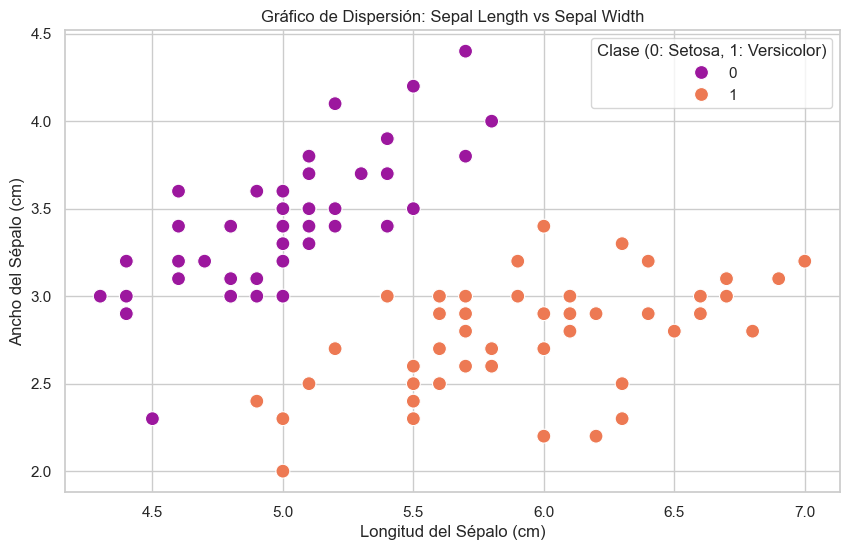

In [8]:
# Cargar el dataset Iris
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Filtrar para tener solo 2 clases
# Eliminamos la clase 2 (Virginica) para simplificar el tutorial visualmente
df_binary = df[df['target'] != 2].copy()

# Análisis Estadístico Descriptivo
print("Estadísticas Descriptivas del Dataset (Clases 0 y 1)")
# La función describe() calcula automáticamente count, mean, std, min, y percentiles
stats = df_binary.describe().transpose()
print(stats[['mean', 'std', 'min', 'max']])

# Gráfico de Dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_binary,
    x='sepal length (cm)',
    y='sepal width (cm)',
    hue='target',
    palette='plasma',
    s=100
)
plt.title('Gráfico de Dispersión: Sepal Length vs Sepal Width')
plt.xlabel('Longitud del Sépalo (cm)')
plt.ylabel('Ancho del Sépalo (cm)')
plt.legend(title='Clase (0: Setosa, 1: Versicolor)')
plt.show()

### Entrenamiento del Modelo

Antes de realizar predicciones, debemos dividir nuestros datos en un conjunto de entrenamiento y uno de prueba, para después instanciar y entrenar la clase `LogisticRegression`.

In [22]:
# Selección de variables predictoras (X) y variable objetivo (y)
# Usamos solo dos variables para facilitar la visualización 2D si fuera necesario
X = df_binary[['sepal length (cm)', 'sepal width (cm)']]
y = df_binary['target']

# División de datos: 80% entrenamiento, 20% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

# Instanciar el modelo
model = LogisticRegression()

# Entrenar el modelo
model.fit(X_train, y_train)

print("Modelo entrenado exitosamente")
print(f"Bias (b): {model.intercept_}")
print(f"Coeficientes o pesos (w): {model.coef_}")

Modelo entrenado exitosamente
Bias (b): [-7.74356794]
Coeficientes o pesos (w): [[ 2.94125026 -2.62601089]]


### Prediction

Ahora sí podemos definir una función personalizada que recibe un patrón o instancia, en este caso las características de una flor, y utiliza el modelo entrenado para predecir su clase.

In [14]:
def predecir_patron(sepal_length, sepal_width):
    # Recuperar nombres de columnas aprendidos por el modelo
    try:
        feature_names = model.feature_names_in_
    except AttributeError:
        # Fallback por si el modelo no tiene nombres de features guardados o si se entrenó con solamente numpy
        feature_names = ['sepal length (cm)', 'sepal width (cm)']
    
    # Crear DataFrame con los nombres
    patron = pd.DataFrame([[sepal_length, sepal_width]], columns=feature_names)
    
    prediccion = model.predict(patron)[0]
    nombres_clases = {0: 'Setosa', 1: 'Versicolor'}
    clase_nombre = nombres_clases.get(prediccion)
    
    print(f"Patrón: [Largo: {sepal_length}, Ancho: {sepal_width}] -> Predicción: {prediccion} ({clase_nombre})")
    return clase_nombre

# Pruebas con valores arbitrarios
print("Resultados de Predicción")
predecir_patron(6.0, 2.5)
predecir_patron(5.0, 3.5); # El ; al final es para evitar que Jupyter imprima el valor de retorno de la última línea

Resultados de Predicción
Patrón: [Largo: 6.0, Ancho: 2.5] -> Predicción: 1 (Versicolor)
Patrón: [Largo: 5.0, Ancho: 3.5] -> Predicción: 0 (Setosa)


### Model Evaluation

Para evaluar el desempeño del modelo se utilizará el conjunto de prueba (`X_test`) y las siguientes métricas de rendimiento:

* Accuracy: Es el porcentaje total de predicciones correctas sobre el total de casos.
* Matriz de Confusión: Nos muestra cuántas predicciones fueron correctas e incorrectas por clase.

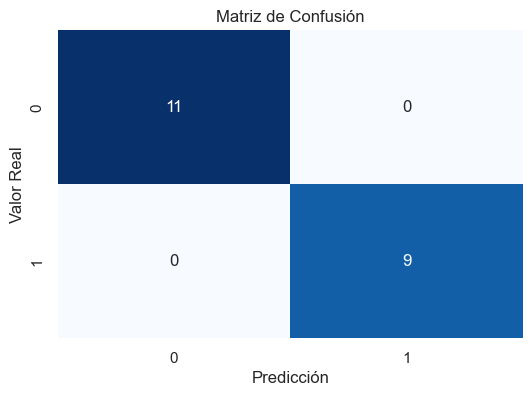

Resultados de la Evaluación:
Accuracy del modelo: 1.00 (o 100.0%)
El modelo clasificó correctamente el 100% de los datos de prueba. Las clases son linealmente separables.


In [20]:
# Realizar predicciones sobre todo el set de prueba
y_pred = model.predict(X_test)

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# Accuracy
acc = accuracy_score(y_test, y_pred)

print(f"Resultados de la Evaluación:")
print(f"Accuracy del modelo: {acc:.2f} (o {acc*100}%)")

if acc == 1.0:
    print("El modelo clasificó correctamente el 100% de los datos de prueba. Las clases son linealmente separables.")
else:
    print(f"El modelo tuvo errores en {1-acc:.2f} proporción de los casos.")

## Referencias

* Ibm. (2025, 4 junio). Regresión logística. Think. https://www.ibm.com/mx-es/think/topics/logistic-regression
* GeeksforGeeks. (2025, 18 noviembre). Logistic Regression in Machine Learning. GeeksforGeeks. https://www.geeksforgeeks.org/machine-learning/understanding-logistic-regression/
* ¿Qué es la regresión logística? - Explicación del modelo de regresión logística - AWS. (s. f.). Amazon Web Services, Inc. https://aws.amazon.com/es/what-is/logistic-regression/